# Problématique 

Code permettant d'entrainer un modèle de reconnaissance text manuscrit.


# Import

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd


In [3]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)

<module 'rendering' from '/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/rendering.py'>

# Chargement du dataframe

In [4]:
# initialisation des variables globales
rss.init()

In [5]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, X_test, y_test = ld_util.get_dataset()

dataset_train_canny, dataset_test_canny, X_test_canny, y_test_canny = ld_util.get_dataset(canny=True)

2023-01-29 15:39:28.327589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
delimiter is deprecated, please use sep instead.


2023-01-29 15:39:29.976 WARNING tensorflow: From /Users/davidbeda/anaconda3/envs/ocr3/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: calling string_split (from tensorflow.python.ops.ragged.ragged_string_ops) with delimiter is deprecated and will be removed in a future version.
Instructions for updating:
delimiter is deprecated, please use sep instead.


In [6]:
# PROPOSITION DB : initialisation d'un iterator pour afficher différents batchs
batch_id=0
iterator = iter(dataset_train)

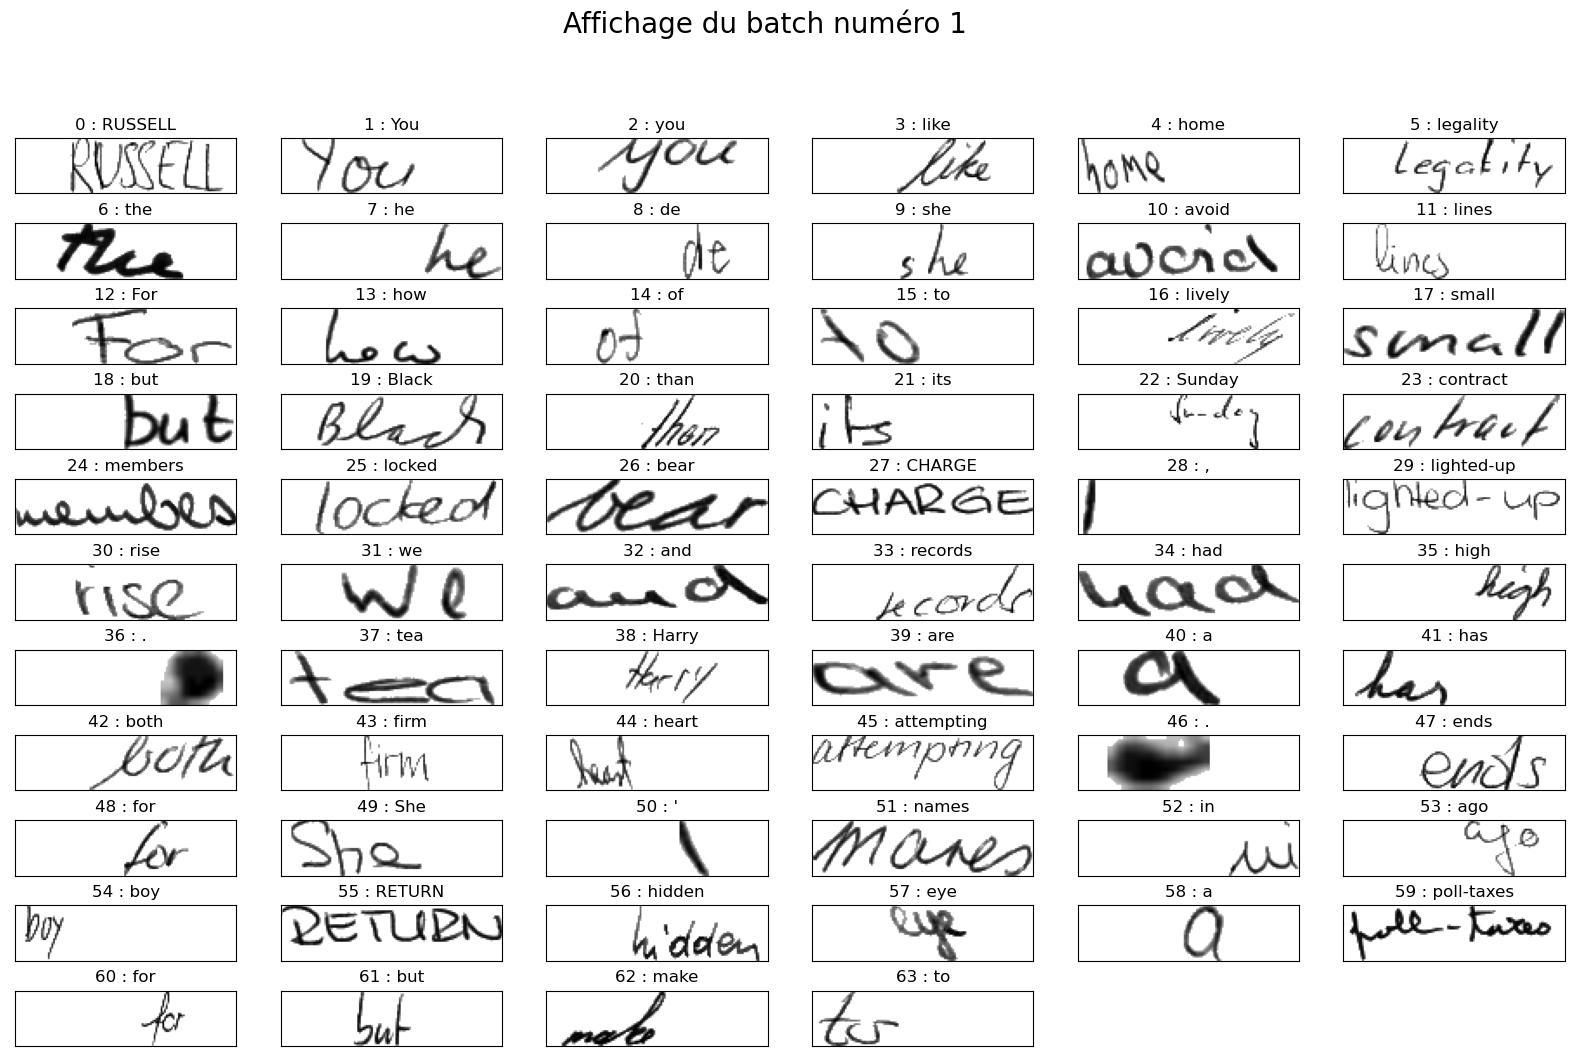

In [7]:
# PROPOSITION DB : lecture des 64 images d'un bacth (le prochain) du dataset d'entrainement

x,y = iterator.get_next()
batch_id +=1
rd.show_iterator_batch(x,y,batch_id)

# Model RNN

### Création Modèle

In [8]:
model = mdl.create_modele()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64)       2

In [9]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)


early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

In [10]:
# chargement du model de référence ou nouvel entraintement

new_training = False

if new_training:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=CTCLoss(), optimizer=optimizer)
    history = model.fit(
        dataset_train,
        validation_data=dataset_test,
        callbacks=[
            early_stop_callback,
            checkpoint_callback
        ],
        epochs=10
    )
else:
    model = tf.keras.models.load_model('../pickle/model_db_ref0', custom_objects={"CTCLoss": CTCLoss})


In [11]:
# OLD
#with open('history.pickle', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

#with open('history.pickle', "rb") as file_pi:
#    history = pickle.load(file_pi)

In [12]:
#x, y = next(iter(dataset_train))
#x.shape

TensorShape([64, 32, 128, 1])

In [17]:
# enregistrement du model

save_model = False

if save_model:
    model.save('../pickle/model_db_ref0')

### Chargement des vecteurs prediction et test

In [20]:
y_test

array(["'", 'the', '#', ..., ',', 'You', 'in'], dtype=object)

In [56]:
y_pred = model.predict(dataset_test)
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)

149/149 [==============================] - 60s 402ms/step


In [ ]:
# Affichage de n tupples de prediction, test
# list(zip(predicted_transcriptions, y_test[:10]))

In [16]:
# OLD : Distance de Levenshtein 

#ld_util.levenshtein_distance(['test','text'], ['text','test'])

#lev_abs = ld_util.levenshtein_distance(predicted_transcriptions, y_test)
#lev_rel = lev_abs / len(y_test)

#print('Score Levenshtein absolu : ', lev_abs)
#print('Scode Levenshtein relatif :', lev_rel)

### Metrique de référence de la prédiction

In [61]:
import metric_orthograph as mo

In [62]:
reload(mo)

<module 'metric_orthograph' from '/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/metric_orthograph.py'>

In [63]:
nb_correction=0

In [64]:
metric_df_0 = mo.metric(y_test, predicted_transcriptions, nb_correction)

In [66]:
#metric_df_0.sample(20)

### Correction orthographique

#### Correction avec 1 modification

In [67]:
nb_correction = 1

predicted_transcriptions_1=[]

for i in range(len(predicted_transcriptions)):
    predicted_transcriptions_1.append(mo.correction(predicted_transcriptions[i], nb_correction))

metric_df_1 = mo.metric(y_test, predicted_transcriptions_1, nb_correction)

In [68]:
#metric_df_1.sample(20)

,test,prediction,nb_correction,levenshtein,cer,acc
7365,",",",",1,0,0.000000,1
906,not,of,1,2,0.666667,0
4115,would,would,1,0,0.000000,1
1918,as,as,1,0,0.000000,1
596,homoeopathy,vomoeoputhy,1,2,0.181818,0
4137,they,they,1,0,0.000000,1
6841,which,which,1,0,0.000000,1
5156,It,It,1,0,0.000000,1
6616,",",",",1,0,0.000000,1
690,.,.,1,0,0.000000,1


#### Correction avec 2 modifications

In [69]:
nb_correction = 2

In [70]:
nb_correction = 2

predicted_transcriptions_2=[]

for i in range(len(predicted_transcriptions)):
    predicted_transcriptions_2.append(mo.correction(predicted_transcriptions[i], nb_correction))

metric_df_2 = mo.metric(y_test, predicted_transcriptions_2, nb_correction)

In [72]:
#metric_df_2.sample(20)

### Concatenation du dataframe avec toutes les métriques

In [79]:
metric_df = pd.concat([metric_df_0, metric_df_1, metric_df_2])

# ajout de la longueur du mot
metric_df['nb_char'] = metric_df.test.apply(lambda x: len(x))

### Analyse graphique des métriques

In [80]:
metric_df.groupby('nb_correction').mean()

/var/folders/96/ccdrmd0x4bl6hk52z36c0g1r0000gn/T/ipykernel_6768/3429451762.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metric_df.groupby('nb_correction').mean()


,levenshtein,cer,acc,nb_char
nb_correction,,,,
0,0.753952,0.164219,0.587144,4.236881
1,0.736459,0.164583,0.661117,4.236881
2,0.731401,0.165365,0.683246,4.236881


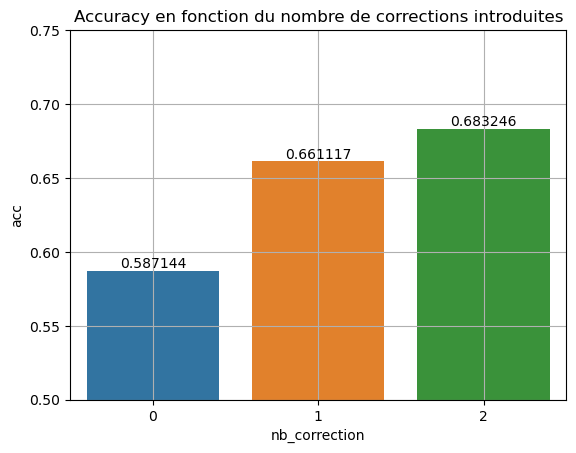

In [81]:
ax = sns.barplot(data=metric_df, x='nb_correction', y = 'acc', errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('Accuracy en fonction du nombre de corrections introduites')
plt.ylim(.5, .75)
plt.grid();

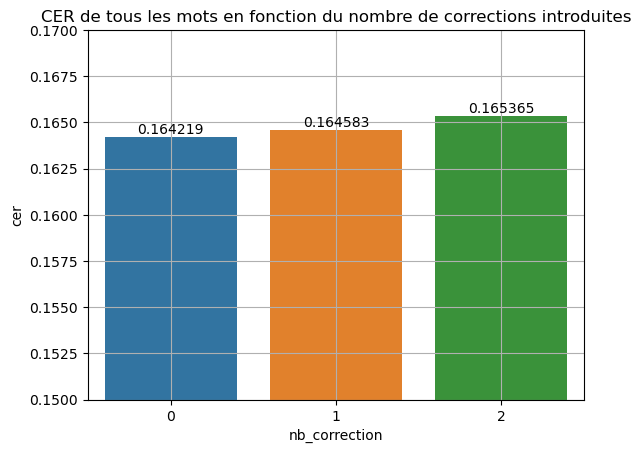

In [82]:
ax = sns.barplot(data=metric_df, x='nb_correction', y = 'cer', errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('CER de tous les mots en fonction du nombre de corrections introduites')
plt.ylim(.15, .17)
plt.grid();

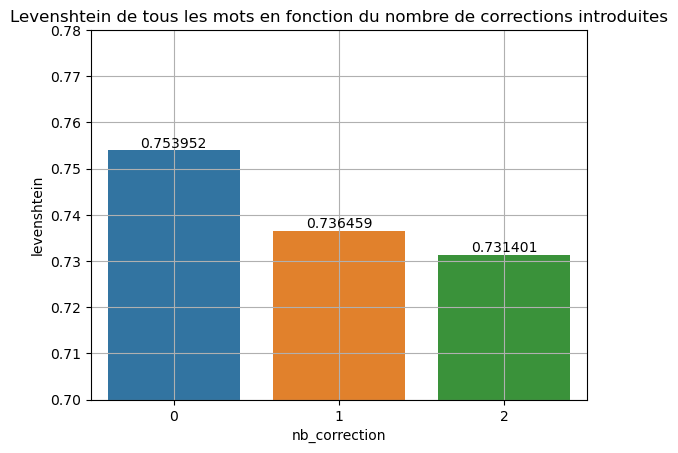

In [91]:
ax = sns.barplot(data=metric_df, x='nb_correction', y = 'levenshtein', errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('Levenshtein de tous les mots en fonction du nombre de corrections introduites')
plt.ylim(.7, .78)
plt.grid();

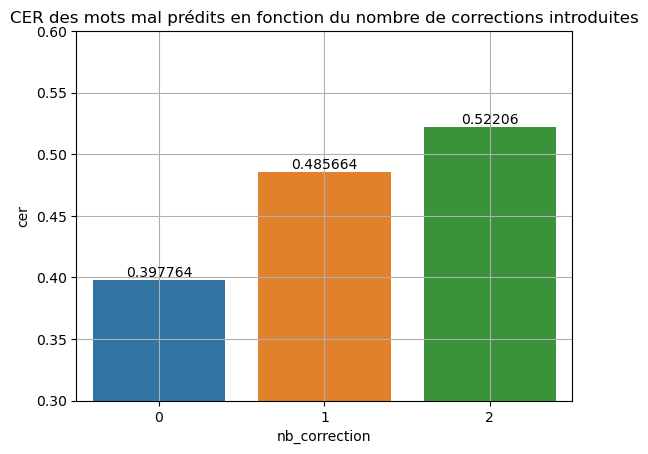

In [83]:
ax = sns.barplot(data=metric_df[metric_df['acc']==0], x='nb_correction', y = 'cer', errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('CER des mots mal prédits en fonction du nombre de corrections introduites')
plt.ylim(.3, .6)
plt.grid();

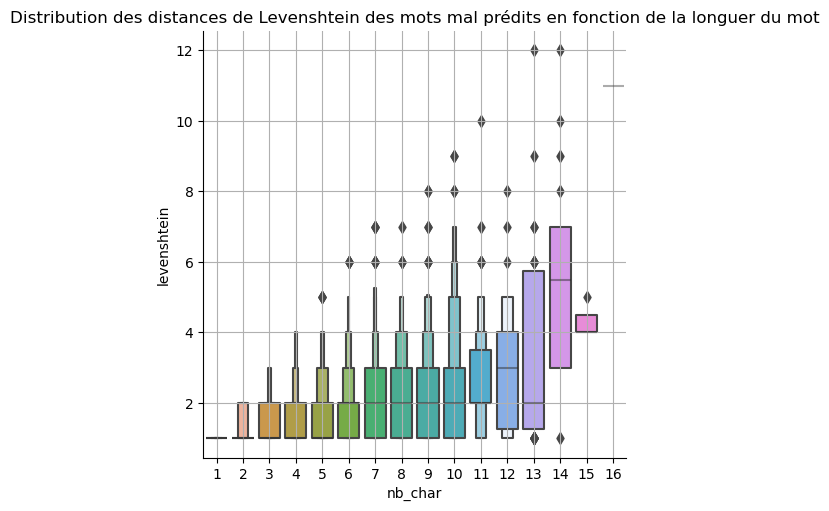

In [84]:
temp_7 = metric_df[(metric_df['cer']<=1) & (metric_df['acc'] == 0)& (metric_df['nb_correction'] == 0)]
sns.catplot(data = temp_7, x = 'nb_char', y='levenshtein', kind='boxen')
plt.title('Distribution des distances de Levenshtein des mots mal prédits en fonction de la longuer du mot')
plt.grid();

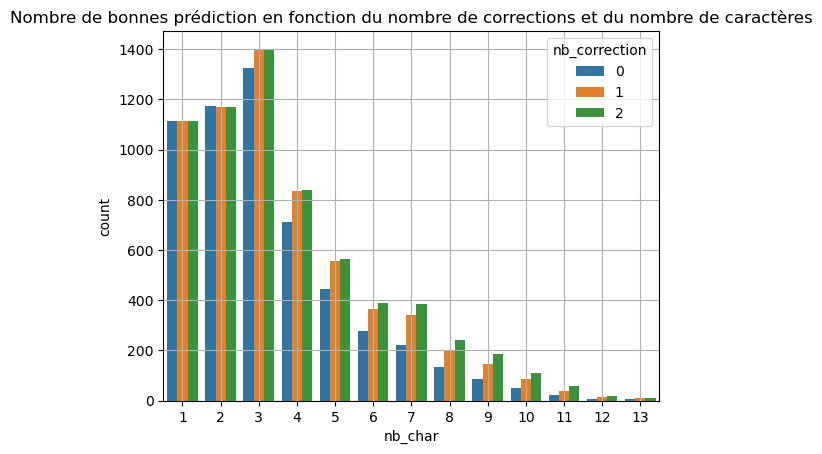

In [85]:
temp_8 = metric_df[(metric_df['acc'] == 1)]
sns.countplot(data = temp_8, x = 'nb_char', hue='nb_correction')
plt.title('Nombre de bonnes prédiction en fonction du nombre de corrections et du nombre de caractères')
plt.grid();

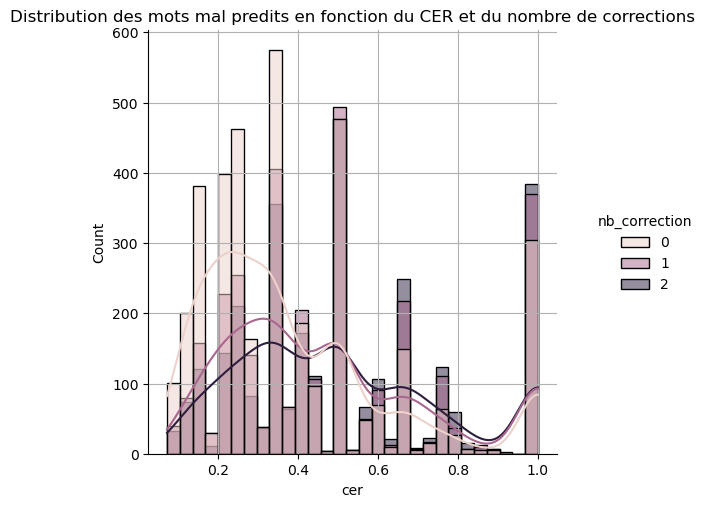

In [87]:
temp_5 = metric_df[(metric_df['cer']<=1) & (metric_df['acc'] == 0)]
sns.displot(data = temp_5, x = 'cer', hue='nb_correction', kde=True)
plt.title('Distribution des mots mal predits en fonction du CER et du nombre de corrections')
plt.grid();

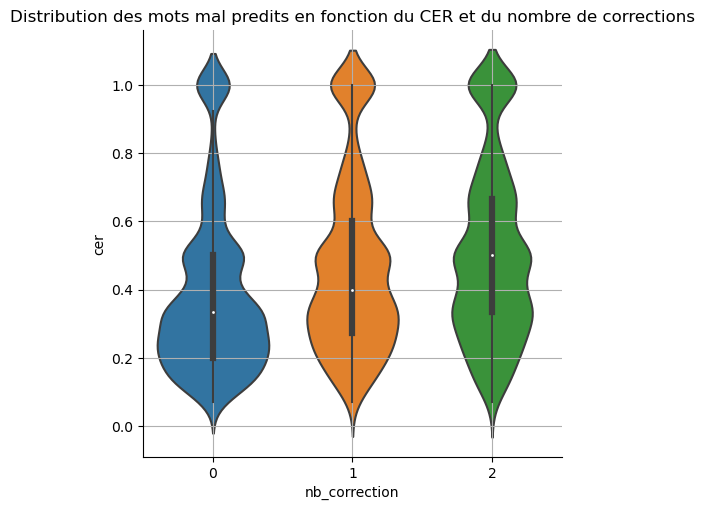

In [93]:
temp_3 = metric_df[(metric_df['cer']<=1) & (metric_df['acc'] == 0)]
sns.catplot(data = temp_3, x = 'nb_correction', y = 'cer', kind='violin')
plt.title('Distribution des mots mal predits en fonction du CER et du nombre de corrections')
plt.grid();

In [95]:
# OLD
# Distance de Levenshtein pour l'influence avec correction ortographique

#lev_abs = ld_util.levenshtein_distance(proposed_correction, y_test)
#lev_rel = lev_abs / len(y_test)

#print('Score Levenshtein absolu : ', lev_abs)
#print('Scode Levenshtein relatif :', lev_rel)

Score Levenshtein absolu :  2992
Scode Levenshtein relatif : 0.3152792413066386


In [98]:
# Avec le correcteur ortographique simple, on obtient une référence de score de Levenshtein relatif de 0,31.
# Soit, une réduction de la distance de 24% par rapport à l'entrainement de base sans correction ortographique

In [ ]:
# TEST correction orthographique v2, (CTC prob)
# NE FONCTIONNE PAS

In [32]:
# Utilisation du beam search decoder au lieu du greedy decoder
# Ceci permet d'avoir accès au top n des chemins de caractères
# A CONSOLIDER : Définition du beam_width à revoir

decoded, log_probabilities = tf.nn.ctc_beam_search_decoder(
    tf.transpose(y_pred, (1, 0, 2)),
    [y_pred.shape[1]]*y_pred.shape[0],
    beam_width=5,
    top_paths=3
)

In [39]:
tf.sparse.to_dense(decoded[0])[0]

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [51]:
for i in range(10):
    print(y_test[i])
    # on commence par la prédiction la plus probable
    predicted_codes = decoded[0]
    
    predicted_codes = tf.cast(predicted_codes, tf.int32)
    codes = tf.sparse.to_dense(predicted_codes)[i]
    print(codes)
    text = decode_codes_test(codes, rss.charList)
    print(text)
    #text = tf.sparse.to_dense(text).numpy().astype(str)

'
tf.Tensor([53  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b',' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
the
tf.Tensor([19  7  4  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b't' b'h' b'e' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
#
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
tf.Tensor(
[b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
before
tf.Tensor([ 1  4  5  8 17  4  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b'b' b'e' b'f' b'i' b'r' b'e' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
and
tf.Tensor([0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
tf.Tensor(
[b'a' b'd' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'

In [30]:
predicted_codes = decoded[0]

codes = tf.cast(predicted_codes, tf.int32)
text = ld_util.decode_codes(codes, rss.charList)
text = tf.sparse.to_dense(text).numpy().astype(str)

print(text)

[[',' '' '' ... '' '' '']
 ['t' 'h' 'e' ... '' '' '']
 ['a' '' '' ... '' '' '']
 ...
 [',' '' '' ... '' '' '']
 ['y' 'o' 'u' ... '' '' '']
 ['i' 'n' '' ... '' '' '']]


In [23]:
tf.sparse.to_dense(codes)

<tf.Tensor: shape=(9490, 16), dtype=int32, numpy=
array([[53,  0,  0, ...,  0,  0,  0],
       [19,  7,  4, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [53,  0,  0, ...,  0,  0,  0],
       [24, 14, 20, ...,  0,  0,  0],
       [ 8, 13,  0, ...,  0,  0,  0]], dtype=int32)>

In [13]:
predicted_codes, neg_sum_logits = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(y_pred, (1, 0, 2)),
        [y_pred.shape[1]]*y_pred.shape[0]
    )

codes = tf.cast(predicted_codes[0], tf.int32)
text = ld_util.decode_codes(codes, rss.charList)
text = tf.sparse.to_dense(text).numpy().astype(str)

print(text)

[[',' '' '' ... '' '' '']
 ['t' 'h' 'e' ... '' '' '']
 ['a' '' '' ... '' '' '']
 ...
 [',' '' '' ... '' '' '']
 ['y' 'o' 'u' ... '' '' '']
 ['i' 'n' '' ... '' '' '']]


In [22]:
codes

In [34]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)

def greedy_decoder(logits, char_list):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(logits, (1, 0, 2)),
        [logits.shape[1]]*logits.shape[0]
    )
    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)
    # Decode the index of caracter
    text = decode_codes(codes, char_list)
    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)
    return list(map(lambda x: ''.join(x), text))
    

In [ ]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

In [52]:
def decode_codes_test(codes, charList):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)